In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
import matplotlib

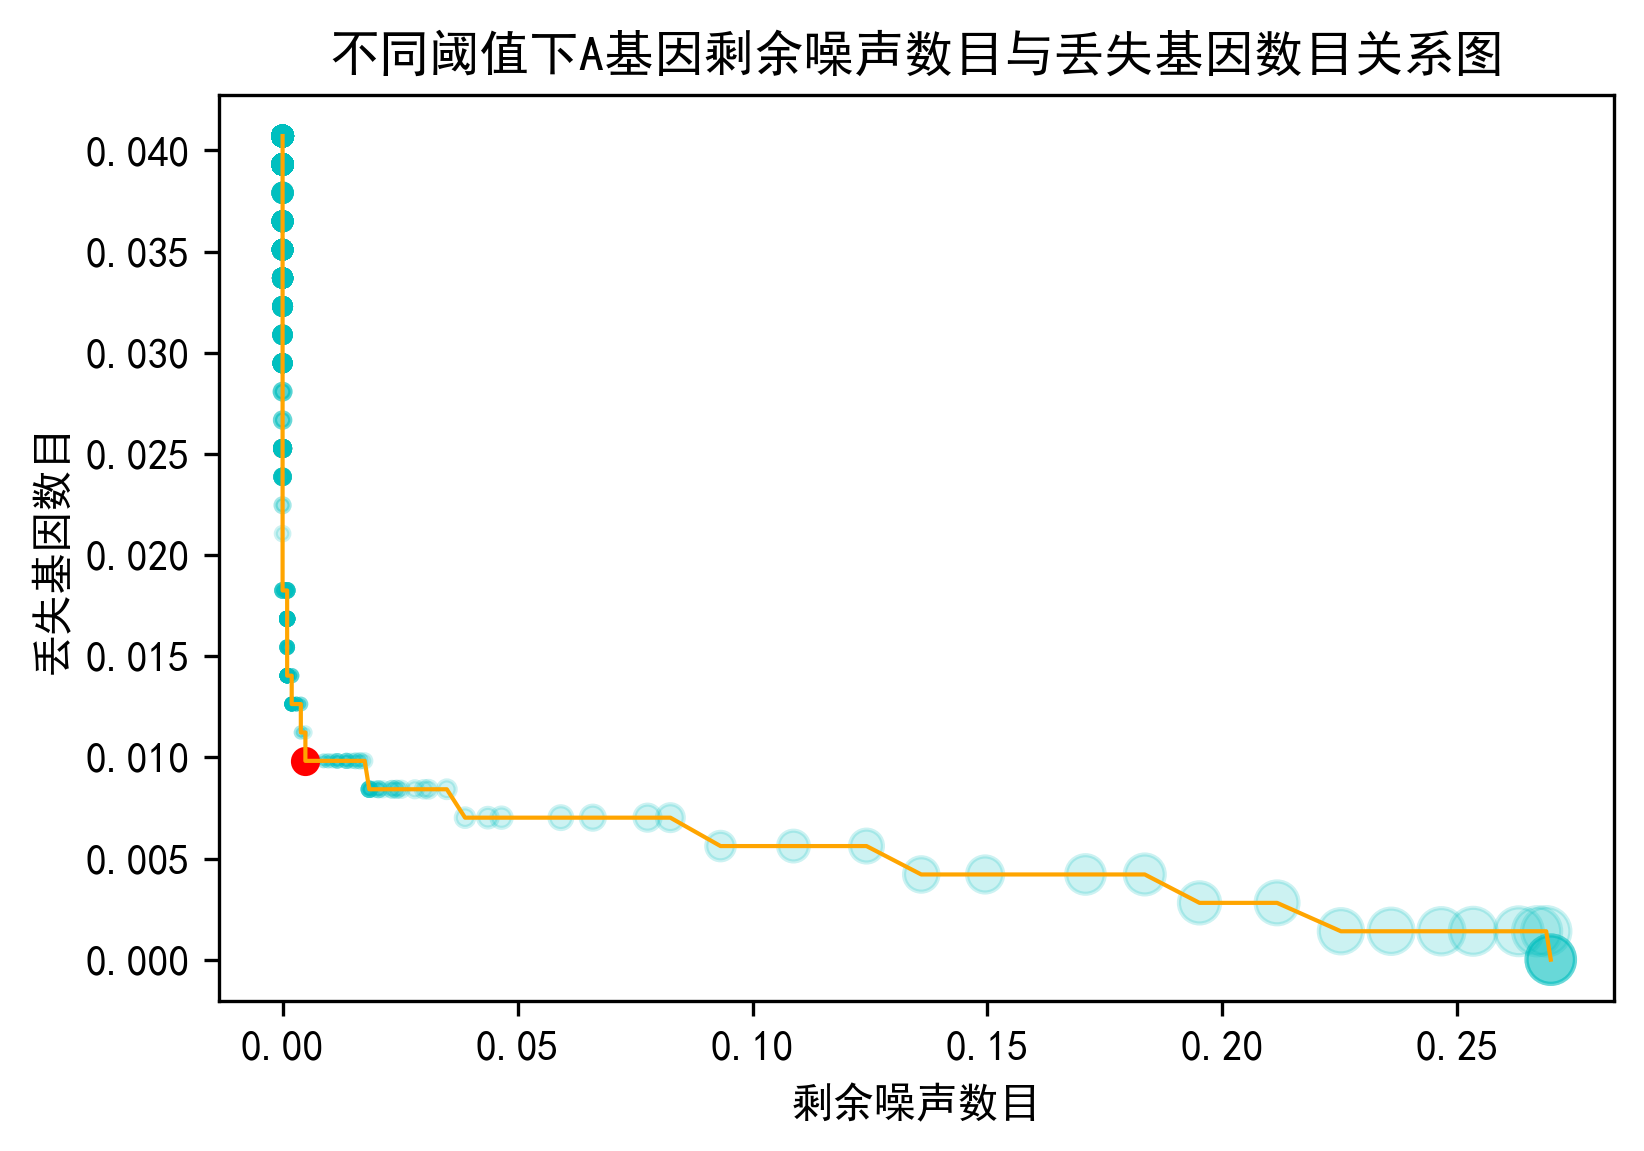

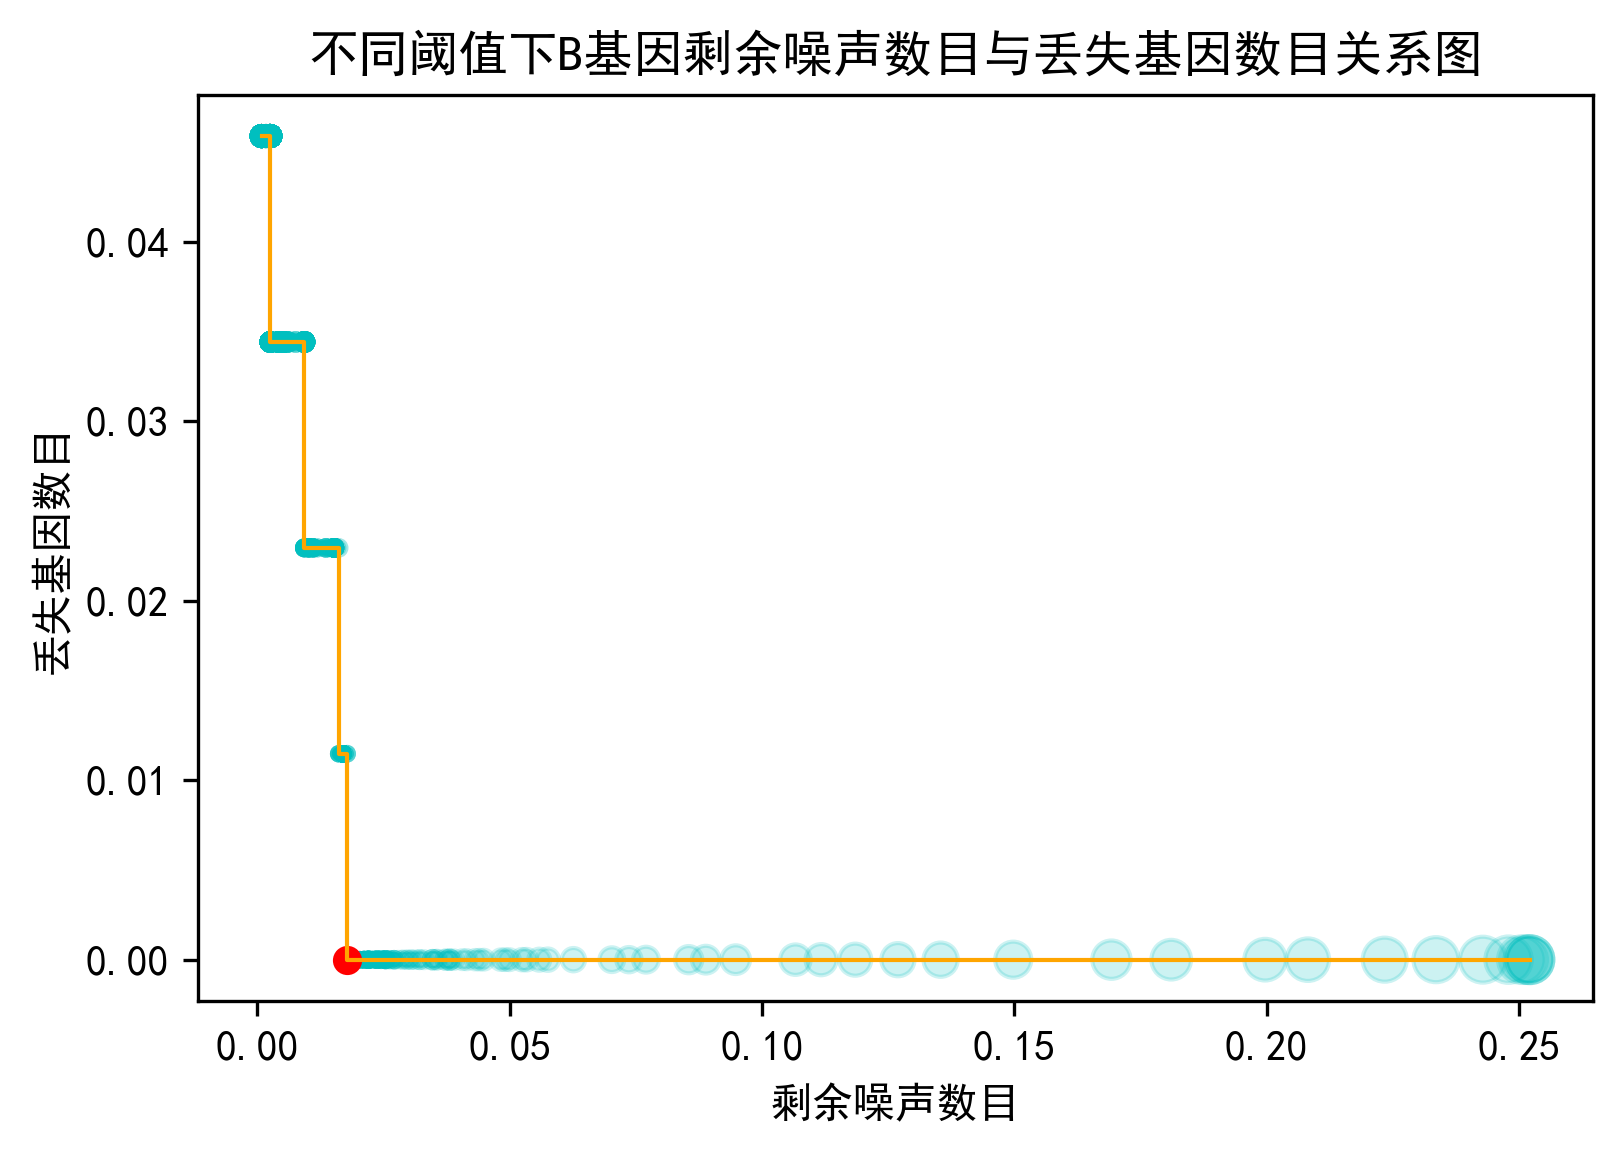

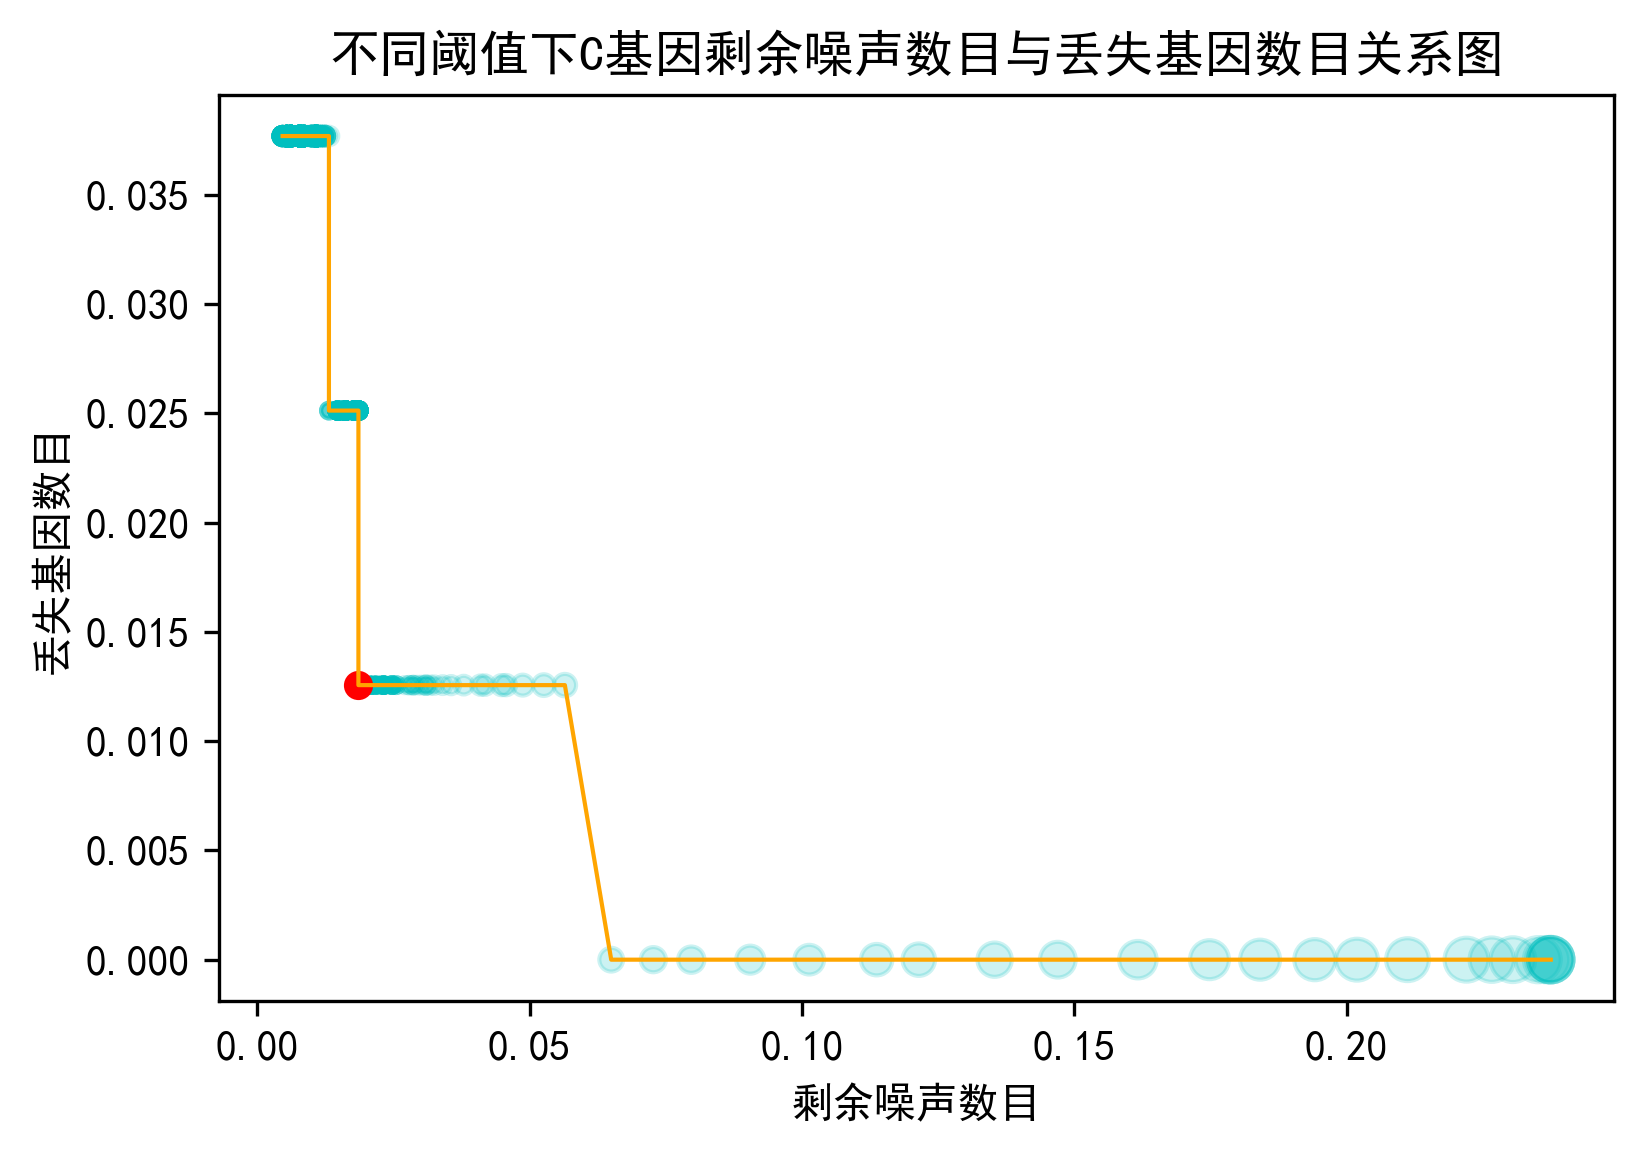

In [8]:
goal_data = {'个体':[], '最佳阈值':[], '剩余噪声数目':[], '剩余噪声概率':[], '丢失基因数目': [], '丢失基因概率':[]}

def f(x, y):
    return np.sqrt(x ** 2 + y ** 2) *500

for person in ['A','B','C']:
    reference = pd.read_csv('data/Refrence.csv')
    # 计算每个个体的基因座上的等位基因
    A_refrence_data = reference[reference['sample'] == person]
    alleles_dict = {A_refrence_data['marker']:[A_refrence_data['allele1'],A_refrence_data['allele2']] for index,A_refrence_data in A_refrence_data.iterrows()}
    delete_list = ['Yindel', 'AMEL', 'DYS391']


    init_data = pd.read_csv(f'data/{person}10pg.hid_Genotype.csv', usecols=['Marker', 'Allele', 'Height', 'Size'])
    init_data = init_data[(init_data['Size'] != 'Dropout') & ~(init_data['Marker'].isin(delete_list))]
    init_data['Height'] = init_data['Height'].apply(pd.to_numeric, errors='coerce').fillna(0.0)

    threshold = 1
    # 阈值列表
    threshold_list = []
    # 剩余噪声数目
    remain_noise_list = []
    # 丢失基因数目
    lost_gene_list = []

    test = None
    while threshold <= 1000:
        error = 0
        remain_gene = 0
        # 过滤掉的数据
        filter_data = init_data[init_data['Height'] < threshold]
        # 过滤后的数据
        remain_data = init_data[init_data['Height'] >= threshold]
        threshold_list.append(threshold)

        for index, row in filter_data.iterrows():
            if str(row['Allele']) == str(alleles_dict[row['Marker']][0]) or str(row['Allele']) == str(alleles_dict[row['Marker']][1]):
                error += 1
                if test is None:
                    test = row
                else:
                    pd.concat([test, row])
        lost_gene_list.append(error)

        for index, row in remain_data.iterrows():
            if str(row['Allele']) != str(alleles_dict[row['Marker']][0]) and str(row['Allele']) != str(alleles_dict[row['Marker']][1]):
                remain_gene += 1
        remain_noise_list.append(remain_gene)
        threshold += 1

    x_norm = Normalizer(norm='l2').fit_transform(np.array(remain_noise_list, dtype='float32').reshape(1, -1))
    y_norm = Normalizer(norm='l2').fit_transform(np.array(lost_gene_list, dtype='float32').reshape(1, -1))

    area_list = [f(x, y) for x, y in zip(x_norm, y_norm)]
    matplotlib.rcParams['font.sans-serif'] = ['SimHei']
    matplotlib.rcParams['font.family']='sans-serif' #解决负号'-'显示为方块的问题
    matplotlib.rcParams['axes.unicode_minus'] = False
    plt.figure(dpi=300)
    plt.title(f'不同阈值下{person}基因剩余噪声数目与丢失基因数目关系图')
    plt.xlabel('剩余噪声数目')
    plt.ylabel('丢失基因数目')
    plt.scatter(x_norm, y_norm, marker='o', alpha=0.2, s=area_list, c='c')

    min_area = min(area_list[0])
    min_index = area_list[0].tolist().index(min_area)
    # print(min_area, min_index)
    min_x = x_norm[0][min_index]
    min_y = y_norm[0][min_index]
    plt.scatter(min_x, min_y, marker='o', alpha=1, c='r')
    plt.plot(x_norm[0], y_norm[0], 'orange', linewidth=1)
    # plt.plot([min_x, min_x], [min_y, 0], c='yellow')
    # plt.plot([min_x, 0], [min_y, min_y], c='green')

    goal_data['个体'].append(person)
    goal_data['最佳阈值'].append(threshold_list[min_index])
    goal_data['剩余噪声数目'].append(remain_noise_list[min_index])
    goal_data['丢失基因数目'].append(lost_gene_list[min_index])
    goal_data['丢失基因概率'].append(lost_gene_list[min_index]/len(init_data))
    goal_data['剩余噪声概率'].append(remain_noise_list[min_index]/len(init_data))

pd.DataFrame(goal_data).to_csv('最佳阈值', index=False)


In [9]:

# with open(f'img/阈值穷举图{person}.png','wb') as f:  
#     plt.savefig(f, format='png', dpi=300)